Import required Python libraries

In [2]:
import scipy.io
import numpy as np
import operator as op

Import and configure matplotlib for plotting

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt # matplotlib
matplotlib.rcParams['figure.figsize'] = list(map(lambda x: 2*x, matplotlib.rcParams['figure.figsize']))
matplotlib.style.use('ggplot')

# Load data set

In [5]:
data = scipy.io.loadmat('../../pancreas_section105.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'boundary_X', 'boundary_Y', 'coordinates', 'mzArray', 'mzdata'])

In [138]:
coorX = np.round((data["coordinates"][0, :]-6669.7) / 85).astype(int)
coorY = np.round((data["coordinates"][1, :]+11984) / 85).astype(int)
coorX -= coorX.min()
coorY -= coorY.min()

nrows = coorX.max() + 1
ncols = coorY.max() + 1

mz_values = data['mzArray']

data_cube = np.zeros((nrows, ncols, mz_values.shape[0]))
data_cube[coorX, coorY, :] = data["mzdata"]

data_matrix = data['mzdata']

In [178]:
row2grid = {r: (coorX[r], coorY[r]) for r in range(data_matrix.shape[0])}
grid2row = {(coorX[r], coorY[r]): r for r in range(data_matrix.shape[0])}

get_bin = lambda mz: np.argmin(np.abs(mz_values - mz))

real_rows = []
real_rows_xy = []
for r in range(nrows):
    for c in range(ncols):
        try:
            row = grid2row[(r, c)]
            real_rows_xy.append((r, c))
            real_rows.append(row)
        except:
            pass
        
real_rows = np.array(real_rows)
real_rows.shape

real_rows_xy = np.array(np.array(real_rows_xy))
real_rows_xy.shape

(10777, 2)

In [179]:
def make_image(rows): # very inefficient implementation but doesnt matter
    """Makes a 2d image from row indices in raw data."""
    img = np.zeros((nrows, ncols))    
    for r in range(nrows):
        for c in range(ncols):
            try:
                row = grid2row[(r, c)]
                img[r, c] = rows[row]
            except:
                pass
    return img

def make_image_real(rows):
    """Makes a 2d image from real rows with data (i.e., rows in real_rows)."""
    img = np.zeros((nrows, ncols)) 
    for idx, val in enumerate(rows):
        x, y = real_rows_xy[idx]
        img[x, y] = val
    return img

# Labeling based on insulin m/z bin

/users/stadius/claesenm/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


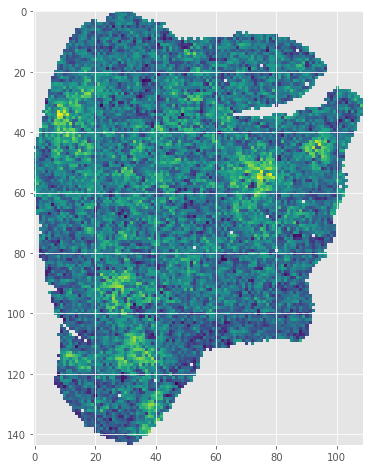

In [165]:
insulin_bin_idx = get_bin(5808) # human insulin protein has molecular mass 5808 Da
#plt.imshow(data_cube[:,:, insulin_bin_idx])

insulin_img = make_image(data_matrix[:, insulin_bin_idx])
plt.imshow(np.log10(insulin_img)) # log10 changes the distribution so we can see what's going on better

(array([    2.,     2.,     6.,    18.,    47.,    69.,    87.,   105.,
          201.,   287.,   248.,   470.,   570.,   517.,   703.,   724.,
          792.,   908.,   996.,   923.,  1031.,   991.,  1000.,   979.,
          962.,   818.,   805.,   748.,   636.,   539.,   458.,   373.,
          293.,   232.,   175.,   155.,   112.,    71.,    64.,    48.,
           37.,    29.,    24.,     6.,     9.,     9.,     3.,     3.,
            2.,     3.]),
 array([-1.79588   , -1.7412583 , -1.6866366 , -1.6320149 , -1.57739321,
        -1.52277151, -1.46814981, -1.41352811, -1.35890642, -1.30428472,
        -1.24966302, -1.19504132, -1.14041963, -1.08579793, -1.03117623,
        -0.97655453, -0.92193284, -0.86731114, -0.81268944, -0.75806774,
        -0.70344604, -0.64882435, -0.59420265, -0.53958095, -0.48495925,
        -0.43033756, -0.37571586, -0.32109416, -0.26647246, -0.21185077,
        -0.15722907, -0.10260737, -0.04798567,  0.00663602,  0.06125772,
         0.11587942,  0.1705011

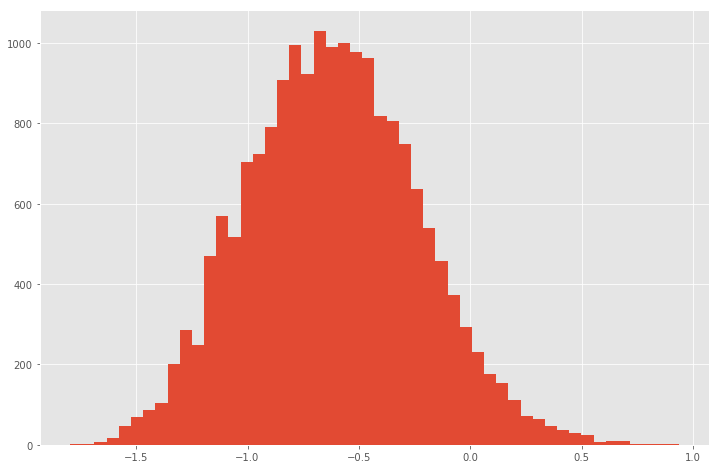

In [166]:
plt.hist(np.log10(data_matrix[:, insulin_bin_idx]), bins=50)

18290 labels, 10777 real data points, 620 positives


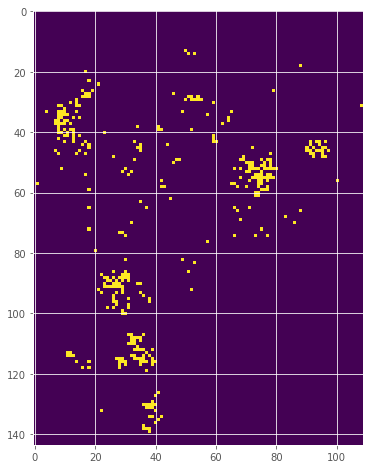

In [255]:
cutoff = 10 ** 0.1

labels = data_matrix[:, insulin_bin_idx] > cutoff
print('%d labels, %d real data points, %d positives' % (len(labels), len(labels[real_rows]), sum(labels)))
#plt.imshow(make_image(labels))

plt.imshow(make_image_real(labels[real_rows]))

In [187]:
real_labels = labels[real_rows]
real_data = data_matrix[real_rows, :]
real_data = real_data[:, np.arange(data_matrix.shape[1]) != insulin_bin_idx]
real_data.shape

(10777, 13296)

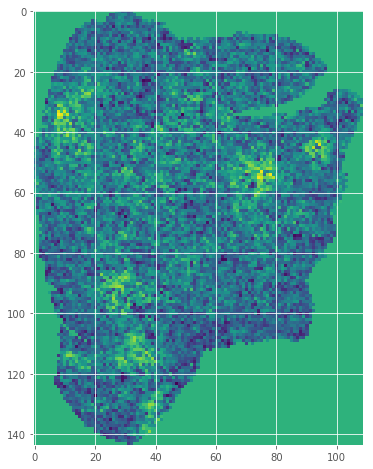

In [190]:
plt.imshow(make_image_real(np.log10(data_matrix[real_rows, insulin_bin_idx])))

In [192]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets
from sklearn.decomposition import PCA as sklearnPCA
from sklearn import preprocessing

see data

In [191]:
X = real_data
X.shape

Y = real_labels
Y.shape

(10777,)

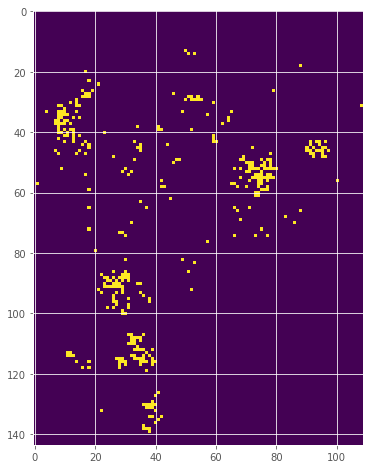

In [193]:
plt.imshow(make_image_real(Y))

## Preprocessing: normalisation & peak picking

In [204]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [256]:
# note: in principle TIC peak picking is done before this step
# secondly: feature selection based on (linear) correlation with labels is not entirely optimal, but included here as an example
data_pp = SelectKBest(chi2, k=100).fit_transform(real_data, real_labels)

# the classification task is too easy, always yielding very high predictive scores
# solutions:
# - remove most informative features
# - add noise to features
# - add noise to labels

In [250]:
scores = None

AttributeError: 'numpy.ndarray' object has no attribute 'transform'

In [257]:
minvals = np.amin(data_pp, 0)
maxvals = np.amax(data_pp, 0)
ranges = 1.0 / (maxvals - minvals)
scaler = np.diag(ranges)

data_pp_scaled = np.dot(data_pp, scaler)
data_pp_scaled.shape

(10777, 100)

# SVM

Code to run nested cross-validation experiment, which involves
- outer cross-validation: 2 folds, returns list of (auc, predictions) per fold
- inner cross-validation: tuning hyperparameters (using 2x3 fold cv)

In [258]:
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics
import optunity
import optunity.metrics
import optunity.cross_validation

In [259]:
# extend data matrix to include spatial location of pixels in first 2 cols
data = np.hstack((real_rows_xy, data_pp_scaled))

@optunity.cross_validated(x=data, y=real_labels, num_folds=2,
                         aggregator=optunity.cross_validation.identity)
def nested_cv(x_train, y_train, x_test, y_test):

    # extract spatial location of pixels (first 2 cols)
    x_train = x_train[:, 2:]
    rows = x_test[:, 0]
    cols = x_test[:, 1]
    x_test = x_test[:, 2:]
    
    # inner cross-validation to estimate performance of a set of hyperparameters
    @optunity.cross_validated(x=x_train, y=y_train, num_folds=3, num_iter=2)
    def inner_cv(x_train, y_train, x_test, y_test, C):
        model = LinearSVC(C=C).fit(x_train, y_train)
        predictions = model.decision_function(x_test)
        roc = optunity.metrics.roc_auc(y_test, predictions)
        #print('auroc in xval: %1.3f' % roc)
        return roc

    hpars, info, _ = optunity.maximize(inner_cv, num_evals=10, C=[0, 10], pmap=optunity.parallel.pmap)
    print('')
    print('Hyperparameters: ' + str(hpars))
    print('Cross-validated AUROC after tuning: %1.3f' % info.optimum)
    model = LinearSVC(**hpars).fit(x_train, y_train)
    predictions = model.decision_function(x_test)
    auc = optunity.metrics.roc_auc(y_test, predictions)    
    return (auc, np.vstack((rows, cols, predictions)))

## Run nested cross-validation procedure and retain results

In [260]:
res = nested_cv()
mean_roc_auc = sum(map(op.itemgetter(0), res)) / len(res)
print('')
print('Mean area under ROC curve in outer cross-validation: %1.3f' % mean_roc_auc)


Hyperparameters: {'C': 8.6279296875}
Cross-validated AUROC after tuning: 1.000

Hyperparameters: {'C': 9.3994140625}
Cross-validated AUROC after tuning: 1.000

Mean area under ROC curve in outer cross-validation: 1.000


### Construct matrix of (out-of-sample) predictions for each pixel.

In [261]:
predictions = np.hstack(map(op.itemgetter(1), res))
prediction_matrix = np.zeros((nrows, ncols))
for i in range(predictions.shape[1]):
    row = predictions[0, i]
    col = predictions[1, i]
    val = predictions[2, i]
    prediction_matrix[row, col] = val

/users/stadius/claesenm/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Plot predictions heatmap

/users/stadius/claesenm/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


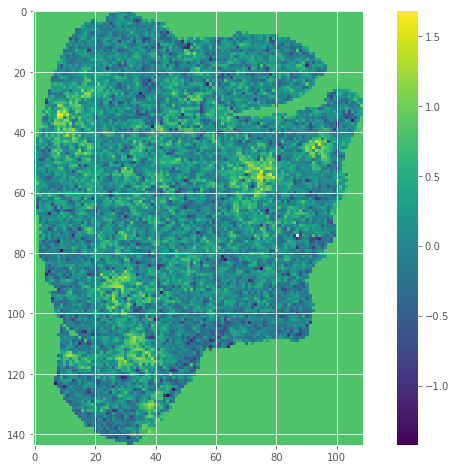

In [264]:
plt.imshow(np.log10(prediction_matrix - prediction_matrix[:].min()))
#plt.imshow(prediction_matrix)
#plt.imshow(prediction_matrix > 0) # default svm treshold
plt.colorbar()